<a id="index"></a>
# DATA PREPARTATION & PREPROCESSING

---------------------------------------------

All preprocessing can be run with `preprocess_data.py`. The script makes use of method chaining in pandas to ensure that processing is carried out in the necessary order (changing this order results in errors). Due to the number of steps, pandas is not ideal; this is a temporary solution that will probably be replaced (potentially with Apache Airflow).  

Required: 
> - The `vocab_20k.txt` and `contractions.txt` files in the same directory (see notebook for details of how these files are used/generated). 
<br>
> - Paths for: 1) a json containing login information for MySQL WorkBench, and 2) the Amazon Comprehend dataset with language detection scores.
<br>
> - If no output directory is specified, all tables are saved to the default folder `output_data`, which will be created if it doesn't already exist. 

The script returns the following tables if `%run` with `-i` in the notebook: `reviews`, `categories`, `locations` and `category_info`. Other saved data - `no_text_df`, `errors_df`, `non_english` can be loaded from the output file. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%time

# method chaining can make debugging difficult
# print outs for each step help to identify potential issues.
%run -i preprocess_data.py --login G:\\aws_processed\\info.json \
                           --aws .\awslanguage_processed_reviews.json

Length of standard stopwords list: 244
Length of extended stopwords list: 955
Dataframe loaded from MySQL WorkBench.
Length of Dataframe: 1690785
Errors removed: 83
Length of Corrected Dataframe: 1690702
Cleaning and replacing nulls...
Average ratings calculated.
Separating no text and text reviews...
Number of samples with text: 918216
Number of text reviews: 918216
Number of no text reviews: 772486
Preprocessing Text...
Number of floats found: 0
Number of English reviews: 610615
Number of non-English/unprocessed reviews: 307601
Removing any additional erroneous samples.
Length Dataframe: 610615
453 additional non-english or non-alpha numeric samples
Final Length: 610162
Processing categories...
Length of Dataframe: 163217
Length of Dataframe after removing errors: 163211
Length of Dataframe: 163211
Length of Dataframe after removing no text reviews: 162977
Cleaning and replacing nulls...
Converting Categories...
Adding preprocessed text to categories
Preprocessing locations...
Cleani

**The notebook provides details & exploratory analysis for the preprocessing steps.**

--------------------------------------------------------
**[1. Load Data & Libraries](#load_data)**
<br>
**[2. Preprocessing](#preprocessing)**
<br> &nbsp;&nbsp;&nbsp; - [Erroneous/Inconsistent Data](#errors)
<br> &nbsp;&nbsp;&nbsp; - [Clean & Sort Data](#clean)
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Combine Headings & Comments](#combine)
<br>
**[3. Categories Preprocessing](#categories)**
<br> &nbsp;&nbsp;&nbsp; - [Clean Categories](#clean_cats)
<br> &nbsp;&nbsp;&nbsp; - [Count Positive/ Negative Categories](#count)
<br> &nbsp;&nbsp;&nbsp; - [Create Sentiment Label](#label)
<br>
**[4. Location Preprocessing](#location)**
<br>
**[5. Add AWS Comprehend Language and Sentiment](#aws)**
<br> &nbsp;&nbsp;&nbsp; - [Create Labeled English Dataset](#labeled_eng)
<br> &nbsp;&nbsp;&nbsp; - [Create English Corpus](#eng_corpus)
<br>
**[6. Text Preprocessing](#preprocess)**
<br> &nbsp;&nbsp;&nbsp; - [Create Stopwords Lists](#stopwords)
<br> &nbsp;&nbsp;&nbsp; - [Custom Tokenizers](#tokens)
<br> &nbsp;&nbsp;&nbsp; - [Analyze Review Vocabulary](#vocab)
<br> &nbsp;&nbsp;&nbsp; - [Split Hashtags](#hashtag)
<br> &nbsp;&nbsp;&nbsp; - [Add Preprocessed Text to Datasets](#lem)
<br>
**[7. Text Features](#features)**
<br> &nbsp;&nbsp;&nbsp; - [Remove Further Errors](#more_errors)
<br>
**[8. Bigrams & Trigrams](#bi_tri)**

<a id="load_data"></a>
# Load Data & Libraries

The data consisted of 140 related databases in MySQL Workbench (restored from an S3 bucket in AWS). All potentially relevant columns were queried and read into pandas dataframes. 

Four tables were created: 

**Reviews**: review text and associated information (such as store, platform, user rating).

**Categories**: human rated categories and corresponding positive/ negative sentiment.

**Locations**: location information for each restaurant.

**Category Info**: additional information about categories (e.g., label, subcategory). 

In [1]:
# Load libraries and configure notebook settings
%matplotlib inline
from libraries import *

pd.set_option('display.max_colwidth', -1)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Query MySQL WorkBench and create relevant dataframes 
with open('G:\\aws_processed\\info.json', 'r') as f:
    d = json.load(f)
    database = d['database']
    password = d['password']

def load_data(password=None, database=None):
    connection = mysql.connector.connect(database=database,
                                         password=password,
                                         host='localhost',
                                         user='root')

    reviews = pd.read_sql("""
    SELECT IFNULL(r.id, 0) AS review_id,
        IFNULL(r.review_comment_heading, "") AS review_heading,
        IFNULL(r.review_comment, "") AS review_comment,
        r.brand_id as brand_id,
        r.store_id as store_id,
        r.date_reviewed as date,
        r.rating_composite AS rating_composite,
        r.platform_id AS platform_id,
        IFNULL(p.name, "") AS platform_name,
        r.rating_1, r.rating_2, r.rating_3, r.rating_4, r.rating_5

    FROM review r JOIN platform p ON r.platform_id = p.id
    LEFT JOIN brand b ON r.brand_id = b.id

    ORDER BY review_id;
    """, con=connection, parse_dates={'date': {'format': '%Y-%m-%d %H:%M:%S'}})

    categories = pd.read_sql("""
    SELECT rhrc.review_id,
        GROUP_CONCAT(CASE WHEN rhrc.is_positive = 1 THEN rhrc.review_category_id END separator ', ')
            as category_pos,
        GROUP_CONCAT(CASE WHEN rhrc.is_positive = 1 THEN rc.name END separator ', ')
            as category_pos_names,
        GROUP_CONCAT(CASE WHEN rhrc.is_positive = 0 THEN rhrc.review_category_id END separator ', ')
            as category_neg,
        GROUP_CONCAT(CASE WHEN rhrc.is_positive = 0 THEN rc.name END separator ', ')
            as category_neg_names

    FROM review_has_review_category rhrc
    LEFT JOIN review_category rc
    ON rhrc.review_category_id = rc.id
    GROUP BY review_id;
    """, con=connection)

    location = pd.read_sql("""
    SELECT longitude, latitude, country, city, brand_id,
           store_id, address_line_1, address_line_2
    FROM address
    WHERE longitude
    IS NOT NULL
    GROUP BY store_id;
    """, con=connection)

    category_info = pd.read_sql("""
    SELECT *
    FROM review_category;
    """, con=connection)

    connection.close()
    return reviews, categories, location, category_info

reviews, categories, locations, category_info = load_data(database=database,
                                                password=password)

reviews.head()

,review_id,review_heading,review_comment,brand_id,store_id,date,rating_composite,platform_id,platform_name,rating_1,rating_2,rating_3,rating_4,rating_5
0,1,Slow service,The food was great but it took a long time to arrive and the floor was quite dirty.,1,2,2015-04-22 09:43:44,2.0,6,GoReview,3.0,2.0,4.0,NaN,NaN
1,2,great service,more about the experience,3,5,2015-04-22 19:41:54,5.0,6,GoReview,4.0,4.0,3.0,5.0,5.0
2,12,Worst service ever,"The service was not good at all, but the cleanliness was average.",1,1,2015-04-27 14:11:14,1.0,6,GoReview,3.0,2.0,4.0,NaN,NaN
3,50,,Test comments,3,6,2015-05-04 08:55:42,2.0,6,GoReview,5.0,3.0,2.0,4.0,3.0
4,106,,Cooment,6,9,2015-06-18 13:55:00,2.0,6,GoReview,2.0,3.0,2.0,3.0,NaN


In [3]:
reviews.info()
reviews.to_json('reviews_unprocessed.json', orient='columns')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690785 entries, 0 to 1690784
Data columns (total 14 columns):
review_id           int64
review_heading      object
review_comment      object
brand_id            int64
store_id            int64
date                datetime64[ns]
rating_composite    float64
platform_id         int64
platform_name       object
rating_1            float64
rating_2            float64
rating_3            float64
rating_4            float64
rating_5            float64
dtypes: datetime64[ns](1), float64(6), int64(4), object(3)
memory usage: 180.6+ MB


In [4]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163217 entries, 0 to 163216
Data columns (total 5 columns):
review_id             163217 non-null int64
category_pos          135980 non-null object
category_pos_names    135980 non-null object
category_neg          36933 non-null object
category_neg_names    36933 non-null object
dtypes: int64(1), object(4)
memory usage: 6.2+ MB


In [5]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5390 entries, 0 to 5389
Data columns (total 8 columns):
longitude         5390 non-null object
latitude          5390 non-null object
country           5352 non-null object
city              5345 non-null object
brand_id          5390 non-null int64
store_id          5390 non-null int64
address_line_1    5335 non-null object
address_line_2    1233 non-null object
dtypes: int64(2), object(6)
memory usage: 337.0+ KB


In [6]:
# Category info was saved for later use 
category_info.info()
#category_info.to_json('category_info.json', orient='columns')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 11 columns):
id                           11426 non-null int64
brand_id                     11426 non-null int64
parent_review_category_id    9680 non-null float64
user_created                 11183 non-null float64
is_positive                  11426 non-null int64
is_sub_category              11426 non-null int64
name                         11424 non-null object
description                  0 non-null object
date_created                 11426 non-null datetime64[ns]
user_updated                 0 non-null object
date_updated                 0 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 982.0+ KB


<a id="preprocessing"></a>
# Preprocessing
[Return to Index](#index)
<a id="errors"></a>
## Erroneous/ Inconsistent Data

Only the reviews table may have erronsous data; for the other tables erroneous data was excluded within the MySQL database query. 

In [7]:
def find_review_errors(df):
    """
    List unique identity key for missing and duplicate reviews, 
    as well as out of range ratings.

    params:
    df: Dataframe containing review information queried from MySQL WB.
    """
    ratings = ['rating_1', 'rating_2', 'rating_3',
                   'rating_4', 'rating_5', 'rating_composite']
    errors_ids = []

    missing = df.review_id[df[ratings].isnull().all(1)]
    out_of_range = df.review_id[((df[ratings] > 5) | (df[ratings] < 0)).any(1)]
    duplicates = df.review_id[df['review_id'].duplicated()]
    errors_ids += list(missing) + list(out_of_range) + list(duplicates)
    return list(set(errors_ids))

def preprocess_errors(df):
    """Return dataframe with errors. Remove errors from review dataset."""
    error_ids = find_review_errors(df)
    error_df = df[df.review_id.isin(error_ids)]
    no_error_df = df[~df.review_id.isin(error_ids)]
    try:
        assert len(df) - len(no_error_df) == len(error_df)
    except:
            print('WARNING: Errors not removed')
    return no_error_df, error_df

def remove_errors(df, error_df):
    """Remove duplicate reviews, or reviews with missing/inaccurate 
    ratintgs."""
    error_review_id = list(error_df.review_id)
    no_error_df = df[~df.review_id.isin(error_review_id)]
    return no_error_df

# 83 reviews were removed for containing erroneous
# ratings, missing review ids, or duplicate ids
reviews, error_df = preprocess_errors(reviews)
print('Number of rows with errors: {}'.format(len(error_df)))

error_df.head()

Number of rows with errors: 83


,review_id,review_heading,review_comment,brand_id,store_id,date,rating_composite,platform_id,platform_name,rating_1,rating_2,rating_3,rating_4,rating_5
8542,13263,,This place is one of the greatest burger places in Joburg (I stand to be corrected though). The food here is amazing and coupled with great service you won't be disappointed. The prices are also quite reasonable if you'd like to catch a lunch date or whatever the occasion,6,428,2016-03-04 00:00:00,9.9,4,Zomato,1.0,1.0,1.0,1.0,NaN
9295,14223,,"Thoroughly enjoyed the food, the service and the vibe. It took about 10 - 15 mins for the food to arrive with a full restaurant.\r\n\r\nThe burgers were phenomenal and the portions of chips were pretty huge.\r\n",6,508,2016-03-29 00:00:00,9.9,4,Zomato,1.0,1.0,1.0,1.0,NaN
30284,42506,,,3,5,2015-04-23 20:27:11,NaN,6,GoReview,NaN,NaN,NaN,NaN,NaN
30285,42512,,,1,1,2015-04-28 01:43:20,NaN,6,GoReview,NaN,NaN,NaN,NaN,NaN
30286,42513,,,3,5,2015-04-29 15:15:01,NaN,6,GoReview,NaN,NaN,NaN,NaN,NaN


<a id="clean"></a>
## Clean and Sort

Pandas ```read_sql``` does not convert MySQL missing values into a compatible format. Missing text was converted directly into empty strings from MySQL. The remaining missing values were all converted to ```np.nan``` values for further processing.  

In [8]:
def find_floats(df, text_cols):
    """List all floats in text/object datatype columns."""
    floats = []
    for i in df.index:
        for col in text_cols:
            if isinstance(df[col][i], float):
                floats.append(i)
    return floats

def remove_line_endings(df, verbose=False):
    """Remove line endings. If verbose, all columns with and without line 
    endings will be printed."""
    
    line_endings = ['\r\n', '\r', '\n\n', '\r\r', '\n', '\t', '\t\t']
    
    df = df.replace(line_endings,' ', regex=True).copy()
    
    for col in df.columns:
        if df[col].dtype == 'object':
            for line_ending in line_endings:
                total_line_endings = df[col].str.contains(line_ending, regex=True).sum()
                try: 
                    assert total_line_endings == 0
                    if verbose:
                        print('No line endings in {}'.format(col))
                except:
                    print('The following columns have line endings {}'.format(col))   
    return df
                    

def clean_and_replace_nulls(df, verbose=False):
    """ Replace all nulls and empty strings with np.nan 
    (standard numpy null value)."""
    
    df = remove_line_endings(df)
    list_missing = ['NaN', 'nan', 'None', [None], 'NULL', '', ' ']
    df = df.replace(list_missing, np.nan).copy()
    return df

def average_ratings(df):
    """ Return dataframe with average rating for reviews with subratings
    (and no composite rating). 
        
    If only the composite exists, fill the new ratings column with 
    the previous composite value. """
    
    ratings = ['rating_1', 'rating_2', 'rating_3',
               'rating_4', 'rating_5', 'rating_composite']
    
    df['rating'] = df[['rating_1', 'rating_2', 'rating_3',
                       'rating_4', 'rating_5']].mean(axis=1)

    df['rating'] = df['rating'].fillna(df['rating_composite'])
    df['rating'] = df['rating'].apply(lambda x: round(x, 0))
    
    df = df.drop(ratings, axis=1).copy()
    try:
        assert len(df.index[(df['rating'] > 5)]) == 0
        assert len(df.index[(df['rating'] < 0)]) == 0
        assert len(df.index[(df['rating'].isnull())]) == 0
    except Exception as e: print(e)
    return df
    

def separate_reviews(df):
    """Return two datasets, one with text reviews (in either the heading 
    or comment) and one where there was no meaningful text (i.e., single 
    digit or letter)."""
    
    # Get review ids for text in headings and comments
    heading = set(df.review_id[df['review_heading'].notnull()])
    comment = set(df.review_id[df['review_comment'].notnull()])
    
    # Replace np.nan with empty string to remove floats
    df['review_heading'] = df['review_heading'].replace(np.nan, '')
    df['review_comment'] = df['review_comment'].replace(np.nan, '')
    
    # Certain reviews contain a single number and should be 
    # separated into the no_text reviews dataset
    single_value_reviews = []
    for i in df.index:
        if (len(df.review_heading[i]) + len(df.review_comment[i])) <=1:
            single_value_reviews.append(df.review_id[i])
    
    # Create list of review ids for text and no text datasets
    with_text = heading.union(comment)
    with_text -= set(single_value_reviews)
    without_text = set(df.review_id) - with_text 
    
    # Create separate databases with and without review text
    text_df = df[df.review_id.isin(with_text)].copy()
    no_text_df = df[df.review_id.isin(without_text)].copy()
    
    try:
        assert len(without_text) + len(with_text) == len(df.index)
    except:
        print('Length of text and no text datasets incorrect')
    
    try:
        assert len(text_df.loc[(text_df['review_heading'] == '') & (text_df['review_comment'] == '')]) == 0
    except:
        print('There are no text reviews in the text dataset')
    
    try:
        assert len(no_text_df.loc[(no_text_df['review_heading'] != '') & (no_text_df['review_comment'] != '')]) == 0
    except:
        print('There are text reviews in the no text dataset')
    
    try:
        assert find_floats(text_df, ['review_heading', 'review_comment']) == []
    except:
        print('Mixed datatypes were present in the text review dataset')
    
    return text_df, no_text_df

In [9]:
%%time
reviews = clean_and_replace_nulls(reviews)

average_ratings(reviews)

text_df, no_text_df = separate_reviews(reviews)

Wall time: 3min 53s


In [10]:
text_df.rating.describe()

count    918216.000000
mean     4.343118     
std      1.094375     
min      0.000000     
25%      4.000000     
50%      5.000000     
75%      5.000000     
max      5.000000     
Name: rating, dtype: float64

In [11]:
no_text_df['rating'].describe()

count    772486.000000
mean     4.293293     
std      0.987783     
min      0.000000     
25%      4.000000     
50%      5.000000     
75%      5.000000     
max      5.000000     
Name: rating, dtype: float64

<a id="combine"></a>
## Combine Review Headings and Comments

In [12]:
text_df['combined'] = text_df.review_heading + ' ' + text_df.review_comment 

text_df.head()

,review_id,review_heading,review_comment,brand_id,store_id,date,rating_composite,platform_id,platform_name,rating_1,rating_2,rating_3,rating_4,rating_5,rating,combined
0,1,Slow service,The food was great but it took a long time to arrive and the floor was quite dirty.,1,2,2015-04-22 09:43:44,2.0,6,GoReview,3.0,2.0,4.0,NaN,NaN,3.0,Slow service The food was great but it took a long time to arrive and the floor was quite dirty.
1,2,great service,more about the experience,3,5,2015-04-22 19:41:54,5.0,6,GoReview,4.0,4.0,3.0,5.0,5.0,4.0,great service more about the experience
2,12,Worst service ever,"The service was not good at all, but the cleanliness was average.",1,1,2015-04-27 14:11:14,1.0,6,GoReview,3.0,2.0,4.0,NaN,NaN,3.0,"Worst service ever The service was not good at all, but the cleanliness was average."
3,50,,Test comments,3,6,2015-05-04 08:55:42,2.0,6,GoReview,5.0,3.0,2.0,4.0,3.0,3.0,Test comments
4,106,,Cooment,6,9,2015-06-18 13:55:00,2.0,6,GoReview,2.0,3.0,2.0,3.0,NaN,2.0,Cooment


<a id="categories"></a>
# Categories Preprocessing
[Return to Index](#index)
<a id="clean_cats"></a>
## Clean Data

In [13]:
categories_no_errors = remove_errors(categories, error_df)

# five enteries were removed from categories df
print('Length of categories dataset without errors: {}'.format(len(categories_no_errors)))

# remove no text reviews from from categories
print('{} reviews in categories had no text'.format(categories.review_id.isin(no_text_df.review_id).sum()))

categories = categories[~categories.review_id.isin(no_text_df.review_id)].copy()

clean_and_replace_nulls(categories)

Length of categories dataset without errors: 163211
234 reviews in categories had no text


,review_id,category_pos,category_pos_names,category_neg,category_neg_names
0,41645,"628, 617, 661, 648, 643","Taste, Food, Sushi, Waitron, Service","653, 649","Waiting Times, Service"
1,52380,"343, 313, 321, 1307, 812","Service, Food, Steaks, Poultry, Sides",NaN,NaN
2,54468,NaN,NaN,344,Service
3,54721,"343, 313, 349, 345","Service, Food, Manager, Waitron",NaN,NaN
4,55999,"681, 679","Burgers, Food","715, 711, 671, 669","Waiting Times, Service, Facilities, Atmosphere"
...,...,...,...,...,...
163212,1749298,NaN,NaN,"12495, 12505","App, Order Ahead Failures"
163213,1749302,NaN,NaN,711,Service
163214,1749306,705,Service,NaN,NaN
163215,1749364,NaN,NaN,"12495, 12507","App, No loyalty earned on a transaction."


<a id="count"></a>
## Count Positive and Negative Category Ratings

In [14]:
cats = ['category_pos', 'category_neg']
new_cols = ['pos_count', 'neg_count']

def convert_cols(df, cats, new_cols):
    """ cats: list of category columns to be summed. 
    new_cols = list of new columns to be added
    
    Return dataframe with columns that sum up negative
    and positive categories for each review."""

    for cat, new_col in zip(cats, new_cols):
        df[cat] = df[cat].replace(np.nan, '')
        df[cat] = df[cat].astype(str)
        df[cat] = df[cat].apply(lambda x: x.split(',') if x != '' else '')
        df[new_col] = df[cat].apply(lambda x: len(x))

convert_cols(categories, cats, new_cols)

categories.head()

,review_id,category_pos,category_pos_names,category_neg,category_neg_names,pos_count,neg_count
0,41645,"[628, 617, 661, 648, 643]","Taste, Food, Sushi, Waitron, Service","[653, 649]","Waiting Times, Service",5,2
1,52380,"[343, 313, 321, 1307, 812]","Service, Food, Steaks, Poultry, Sides",,None,5,0
2,54468,,None,[344],Service,0,1
3,54721,"[343, 313, 349, 345]","Service, Food, Manager, Waitron",,None,4,0
4,55999,"[681, 679]","Burgers, Food","[715, 711, 671, 669]","Waiting Times, Service, Facilities, Atmosphere",2,4


<a id="label"></a>
## Create Sentiment Label

In [15]:
def get_cat_labels(data):
    """Return sentiment labels based on sum of negative and positive categories
    for each review. 
    
    Sentiment is a multiclass label where: 0 -> negative, 1 -> positive, 2 -> mixed.
    (i.e., was a review positive, negative or mixed.)
    
    Positive and negative label columns were also addded for multilabel analysis 
    (i.e., was a review positive, negative, or both). """
    
    df = data.copy()
    df.loc[(df['pos_count'] > 0) & (df['neg_count'] == 0), 'sentiment'] = 1
    df.loc[(df['pos_count'] == 0) & (df['neg_count'] > 0), 'sentiment'] = 0
    df.loc[(df['pos_count'] > 0) & (df['neg_count'] > 0), 'sentiment'] = 2
    
    df.loc[(df['pos_count'] > 0), 'positive'] = 1
    df.loc[(df['neg_count'] > 0), 'negative'] = 1
    df.loc[(df['pos_count'] == 0), 'positive'] = 0
    df.loc[(df['neg_count'] == 0), 'negative'] = 0
    return df

categories = get_cat_labels(categories)

categories.head()

,review_id,category_pos,category_pos_names,category_neg,category_neg_names,pos_count,neg_count,sentiment,positive,negative
0,41645,"[628, 617, 661, 648, 643]","Taste, Food, Sushi, Waitron, Service","[653, 649]","Waiting Times, Service",5,2,2.0,1.0,1.0
1,52380,"[343, 313, 321, 1307, 812]","Service, Food, Steaks, Poultry, Sides",,None,5,0,1.0,1.0,0.0
2,54468,,None,[344],Service,0,1,0.0,0.0,1.0
3,54721,"[343, 313, 349, 345]","Service, Food, Manager, Waitron",,None,4,0,1.0,1.0,0.0
4,55999,"[681, 679]","Burgers, Food","[715, 711, 671, 669]","Waiting Times, Service, Facilities, Atmosphere",2,4,2.0,1.0,1.0


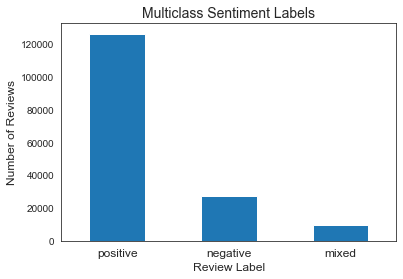

In [16]:
categories.sentiment.value_counts().plot(kind='bar')

plt.title('Multiclass Sentiment Labels', fontsize=14)
plt.xticks(ticks=np.arange(3), labels=['positive', 'negative', 'mixed'], rotation=0,
           fontsize=12)
plt.xlabel('Review Label', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12);

<a id="location"></a>
# Location Preprocessing
[Return to Index](#index)

In [17]:
%%time
# location data will be used later on to geospatially visualize
# sentiment for various restaurant chains and brands
locations = clean_and_replace_nulls(locations)

locations.isnull().sum()

Wall time: 288 ms


longitude         0   
latitude          0   
country           38  
city              45  
brand_id          0   
store_id          0   
address_line_1    55  
address_line_2    4166
dtype: int64

<a id="aws"></a>
# Add AWS Comprehend Language and Sentiment
[Return to Index](#index)

In [18]:
# A sample of the data were processed by Amazon Comprehend for
# sentiment and language detection
aws_processed = pd.read_json('aws_processed_new_dataset.json', orient='columns')
aws_processed.reset_index(inplace=True, drop=True)

aws_processed_cut = aws_processed[['review_id','aws_lang', 'aws_lang_score', 'aws_mix', 
                                   'aws_neg', 'aws_neu', 'aws_pos','aws_sent']]

aws_processed_cut.head()

,review_id,aws_lang,aws_lang_score,aws_mix,aws_neg,aws_neu,aws_pos,aws_sent
0,1,en,0.993903,0.763733,0.229482,0.002765,0.004021,MIXED
1,2,en,0.988039,0.018287,0.008111,0.031472,0.942129,POSITIVE
2,12,en,0.991282,0.231639,0.767219,0.000849,0.000292,NEGATIVE
3,50,en,0.949631,0.002727,0.010144,0.950454,0.036675,NEUTRAL
4,106,en,0.575703,0.004087,0.016755,0.939358,0.039800,NEUTRAL


In [21]:
# Join to the labeled categories table
cat_df = pd.merge(categories, aws_processed_cut, on='review_id', how='left')

# while all categories were allocated a langauge score, sentiment was 
# only carried out for 6 langauges, which is why there were approximately
# 2600 sentiment labels missing. 

print('Number of labeled reviews without AWS sentiment labels: {}'\
      .format(cat_df.aws_lang.notnull().sum() - cat_df.aws_sent.notnull().sum()))

# these 6 langauges processed by Comprehend have sentiment scores
languages = ['en','de', 'fr', 'es', 'it', 'pt']
print('Number of reviews with en, de, fr, es, it, pt language codes: {}'\
      .format(cat_df.aws_lang.str.contains('|'.join(languages)).sum()))

print('Number of labeled English reviews: {}'\
      .format((cat_df.aws_lang=='en').sum()))

Number of labeled reviews without AWS sentiment labels: 2609
Number of reviews with en, de, fr, es, it, pt language codes: 160368
Number of labeled English reviews: 159043


<a id="labeled_eng"></a>
## Create Labeled English Dataset

In [22]:
# remove non-english reviews from labeled dataset
english_cat = cat_df[cat_df.aws_lang== 'en']

# create and save non-english categories table  
non_english_cat = cat_df[~cat_df.review_id.isin(english_cat.review_id)]

# check that all category data is accounted for
len(english_cat) + len(non_english_cat) == len(cat_df)

True

<a id="eng_corpus"></a>
## Create English Corpus

Additional datasets were run through Amazon Comprehend Language Detection API to build a larger english text corpus - necessary to improve word vectors and determine overarching patterns in the review data across brands and platforms. 

In [23]:
# load additional aws language processed reviews 
aws_lang_processed = pd.read_json('awslanguage_processed_reviews.json', orient='columns')

# create a cut dataframe with relevant columns to merge
aws_cut = aws_lang_processed[['review_id', 'aws_lang']].copy()
aws_cut = aws_cut.reset_index(drop=True)
text_df = text_df.reset_index(drop=True)

# merge with text reviews
lang_processed = pd.merge(text_df, aws_cut, on='review_id', how='left')\
                   .reset_index(drop=True)\
                   .sort_values('aws_lang')\
                   .drop_duplicates('review_id', keep='first')\
                   .dropna(subset=['combined'])

# select all English reviews
english = lang_processed[lang_processed.aws_lang == 'en'].copy()
print('Number of English reviews: {}'.format(len(english)))

# select all non-English reviews
non_english = lang_processed[~lang_processed.index.isin(english.index)].copy()
print('Number of non-English/unprocessed reviews: {}'.format(len(non_english)))

Number of English reviews: 610615
Number of non-English/unprocessed reviews: 307601


<a id="preprocess"></a>
# Text Preprocessing
[Return to Index](#index)


In [110]:
# Get datasets with AWS language scores - split up for batch processing
aws_lang_processed = pd.read_json('awslanguage_processed_reviews.json', orient='columns')
lang_processed = pd.concat([aws_lang_processed, text_df], axis=1)\
                   .sort_values('aws_lang')\
                   .drop_duplicates('review_id', keep='first')

english = lang_processed.loc[lang_processed.aws_lang == 'en'].copy()
print('Number of reviews with English label: {}'.format(len(english)))

print('Number of labeled English reviews in full text dataset: {}'\
      .format(english_cat.review_id.isin(english.review_id).sum())) 
print('Number of labeled English reviews: {}'.format(len(english_cat)))

Number of reviews with English label: 611151
Number of labeled English reviews in full text dataset: 159043
Number of labeled English reviews: 159043


<a id="stopwords"></a>
## Create Custom Stopwords Lists

In [111]:
# English stopwords from multiple lists
with open("additional_stopwords.txt", "r") as textfile:
    additional_stopwords = textfile.read().split('\n')

stopwords_list = list(string.punctuation)
stopwords_list += ['....', '...', '..', '.....', 'im']
stopwords_list += stopwords.words('english') # nltk
stopwords_list += get_stop_words('en') # stop words
stopwords_list = list(set(stopwords_list))
stopwords_list = [ w for w in stopwords_list if w not in 'not' ]

print('Length of standard stopwords list: {}'.format(len(stopwords_list)))

extended_stopwords_list = stopwords_list
extended_stopwords_list += spacy.lang.en.stop_words.STOP_WORDS # spacy
extended_stopwords_list += additional_stopwords
extended_stopwords_list = ENGLISH_STOP_WORDS.union(stopwords_list) # sklearn stopwords
extended_stopwords_list = list(set(extended_stopwords_list))
extended_stopwords_list = [ w for w in extended_stopwords_list if w not in 'not' ]
      
print('Length of extended stopwords list: {}'.format(len(extended_stopwords_list)))

Length of standard stopwords list: 244
Length of extended stopwords list: 955


In [112]:
english_vocab = [w.lower() for w in nltk.corpus.words.words()]
english_vocab += [w.lower() for w in nltk.corpus.wordnet.words()]
english_vocab += [w.lower() for w in nltk.corpus.brown.words()]
english_vocab += [w.lower() for w in nltk.corpus.reuters.words()]
english_vocab += [w.lower() for w in nltk.corpus.nps_chat.words()]
english_vocab += [w.lower() for w in nltk.corpus.webtext.words()]
english_vocab = set(english_vocab)

print('The English vocabulary list contains {} words.'.format(len(english_vocab)))

The English vocabulary list contains 365924 words.


<a id="tokens"></a>
## Custom Tokenizers

In [113]:
with open('contractions.txt','r') as f:
    contractions = eval(f.read())

def expand_contractions(str_input):
    """ Replace contracted words with expanded words.
    Example: can't -> cannot, he'll -> he will.

    contractions.txt with dictionary mappings must be in same directory."""
    
    str_input = re.sub(r"[^A-Za-z0-9' ]+", " ", str_input).lower()
    new = re.sub(r"\s+\'", "'", str_input)
    for word in new.split():
        if word in contractions.keys():
            new = new.replace(word, contractions[word])
    return new

def clean_text(str_input):
    """ Returns strings with urls, hashtags, contractions, new line characters,
    and punctuation removed. """
    
    no_url = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", str_input)
    no_contractions = expand_contractions(no_url)
    no_newline = re.sub(r"(?<=[a-z])[\r\n]+"," ", no_contractions)
    no_punc = re.sub(r"[^A-Za-z0-9]+", " ", no_newline)
    return no_punc

def tokenizer(str_input, stop_words=None, lem=False, stem=False):
    """ Returns tokenized string. Optional stopwords removal, lemmatization 
    or stemming."""
    
    str_input = clean_text(str_input)
    words = filter(None, str_input.split())
    words = [w.lower() for w in words]
    stemmer = SnowballStemmer("english")
    lemmer = WordNetLemmatizer()
    if stop_words:
        words = [w for w in words if w not in stop_words]
    if lem:
        words = [lemmer.lemmatize(w, "v") for w in words]
    if stem:
        words = [stemmer.stem(w) for w in words]
        if stop_words:
            words = [w for w in words if w not in stop_words]
    return words

In [114]:
test_sentence = "This restaurant seems to be doing something right, and I can\\'t seem to stay away either. \
From the wide selections of burger toppings, to the absolutely delicious sweet treats \
(milkshakes and flapjacks), I\\'m addicted, (even with its strange location next to the garage).\
www.examplewebsite.com, #bestbest an #outoftheworld'"

print('ORIGINAL TEXT:')
print(test_sentence)
print('-'*120)

# remove punctuation and expand contractions 
print('EXPAND CONTRACTED WORDS:')
print(expand_contractions(test_sentence))
print('-'*120)

# remove punctuation and expand contractions 
print('CLEAN TEXT:')
print(clean_text(test_sentence))
print('-'*120)

# tokenize text
print('RAW WORD TOKENS + EXPAND WORDS:')
print(tokenizer(test_sentence))
print('-'*120)

# tokenize and lemmatize text
print('LEMMED TOKENS:')
print(tokenizer(test_sentence, lem=True))
print('-'*120)

# tokenize, lemmatize and stem text
print('LEMMED + STEMMED TOKENS:')
print(tokenizer(test_sentence, lem=True, stem=True))
print('-'*120)

# remove extended stopwords without stemming
print('LEMMED TOKENS WITHOUT EXTENDED STOPWORDS:')
print(tokenizer(test_sentence, lem=True, stem=False, 
                stop_words=extended_stopwords_list))
print('-'*120)

# remove extended stopwords with stemming
print('LEMMED + STEMMED TOKENS WITHOUT EXTENDED STOPWORDS:')
print(tokenizer(test_sentence, lem=True, stem=True, 
                stop_words=extended_stopwords_list))

ORIGINAL TEXT:
This restaurant seems to be doing something right, and I can\'t seem to stay away either. From the wide selections of burger toppings, to the absolutely delicious sweet treats (milkshakes and flapjacks), I\'m addicted, (even with its strange location next to the garage).www.examplewebsite.com, #bestbest an #outoftheworld'
------------------------------------------------------------------------------------------------------------------------
EXPAND CONTRACTED WORDS:
this restaurant seems to be doing something right  and i cannot seem to stay away either  from the wide selections of burger toppings  to the absolutely delicious sweet treats  milkshakes and flapjacks  I am addicted   even with it is strange location next to the garage www examplewebsite com   bestbest an  outoftheworld'
------------------------------------------------------------------------------------------------------------------------
CLEAN TEXT:
this restaurant seems to be doing something right and i ca

<a id="vocab"></a>
## Analyze Review Vocabulary

In [115]:
# add raw tokens column to full text reviews
english['raw_tokens'] = english['combined'].apply(tokenizer)

reviews = english['raw_tokens'].tolist().copy()
review_tokens_raw = list(itertools.chain.from_iterable(reviews))

fdist = FreqDist(review_tokens_raw)

full_vocab_freq = dict()
for word, frequency in fdist.items():
    full_vocab_freq[word] = frequency
    
print('The review dataset contains {} unique words.'
      .format(len(full_vocab_freq)))
print('There are {} total words in the review corpus.'.format(sum(fdist.values())))
print('Therefore, the lexical diversity in the text is around {0:.2f}%.'
      .format((len(full_vocab_freq)/sum(fdist.values()))*100))

The review dataset contains 81006 unique words.
There are 10195666 total words in the review corpus.
Therefore, the lexical diversity in the text is around 0.79%.


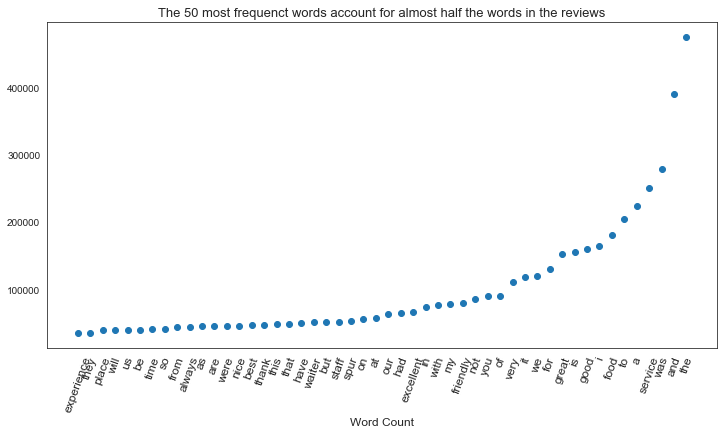

In [116]:
# the top 50 words account for almost half the 
# total words in the entire corpus
most_common_50 = fdist.most_common(50)
most_common_50.sort(key=lambda tup: tup[1])
x, y = list(zip(*most_common_50))

fig = plt.figure(figsize=(12,6))
plt.scatter(x, y)
plt.title('The 50 most frequenct words account for almost \
half the words in the reviews', fontsize=13)
plt.xticks(np.arange(50), labels=[w[0] for w in most_common_50],
           rotation=70, fontsize=12)
plt.xlabel('Common Words', fontsize=12)
plt.xlabel('Word Count', fontsize=12);

In [117]:
# Taking the word lengths and ordering them from longest to shorest
# it becomes obvious that there are many nonsensical reviews, spelling
# mistakes, hashtags, slang adaptations, exclaimations, etc. Many of these
# occur only once in the entire vocab. 

wordlengths = dict()
for word in full_vocab_freq.keys():
    wordlengths[word] = len(word) 
    
sorted_wordlen = sorted(wordlengths.items(), key=lambda kv: kv[1], reverse=True)
sorted_wordlengths = collections.OrderedDict(sorted_wordlen)

for wl in list(sorted_wordlengths.items())[:60]:
    print(wl)

('atcvxcvxxcbbcvvvbnbbbnbbbbbnbbnbbbbnbbbnbnnnbnbbnnbnbbbbnbbnbbbbbbbbbbbvbbbbbnvbbbnbmbbbbbbbbbbbbbbbbbbbbnbnbbbvbbnbbn7zzvzzzddzdzzzzzzzzzzzdzzzzzzzcvv', 151)
('zzzzdzzdzzzszzddzzxdzzszzzzzdzdzzzzzzzkklmzzzxzzzzzzxzzzxxzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxzzzxzzzzzzzzzxzzzxzzzzz', 121)
('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 74)
('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 72)
('flippinwearenotnormalkickassbitememunchetycrunchety', 51)
('sssssssssshhhhhhhhhhiiiiiiiiiitttttttttteeeeeeeeee', 50)
('niceeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee', 50)
('2599999999999998898889988888888888888888888888888', 49)
('vvvvvvvvcvvvuvvvvvvvvvvvvvvvvuvvvuucvvuvvvvvvvvv', 48)
('iuuuuuuuuuuuuyyytttffvuuujhgggyyuhhhgfreeertyuuh', 48)
('awwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwe', 48)
('loooooooooooovvvvvvvvvvvvveeeeeeeeeeeeeeeeeeeee', 47)
('verrrrrrrrrrrrrrrrrrrrrrrrrrrrrrryyyyyyyyyyyyy', 46)
('hadtowaitformyfoodtocome

<a id="hashtag"></a>
## Split Hashtag Function to Tokenizer with Domain Specific Vocab

In [118]:
# The top 20 000 most frequent words were added to 
# a trimmed vocabulary
trimmed_vocab_freq = dict()
for word, frequency in fdist.most_common(20000):
    trimmed_vocab_freq[word] = frequency
    
list(trimmed_vocab_freq.items())[0:10]

[('the', 476000),
 ('and', 391159),
 ('was', 279245),
 ('service', 251571),
 ('a', 223645),
 ('to', 204291),
 ('food', 181160),
 ('i', 164576),
 ('good', 160464),
 ('is', 155302)]

In [119]:
extended_vocab_20k = list(set(list(english_vocab) + list(trimmed_vocab_freq.keys())))

with open("vocab_20k.txt", "w", encoding='utf-8') as file:
    file.writelines( "%s\n" % item for item in extended_vocab_20k )
    
print('The extended vocabulary contains {} words.'.format(len(extended_vocab_20k)))
print('This is {} more than the English vocab.'.format(len(extended_vocab_20k) - len(english_vocab)))

The extended vocabulary contains 371797 words.
This is 5873 more than the English vocab.


In [120]:
def expand_contractions(string_input):
    """Expands contracted words by removing the apostrophe and 
    replacing with full words."""
    string_input = re.sub(r"[^A-Za-z0-9'# ]+", " ", string_input).lower()
    new = re.sub(r"\s+\'", "'", string_input)
    for word in new.split():
        if word in contractions.keys():
            new = new.replace(word, contractions[word])
    return new


def split_hashtag(str_input):
    """ Returns hashtag split into individual words. Wordninja is used 
    to split the hashtag after it has been confirmed that it is not a
    single word in the extended english vocabulary. 
    
    Wordninja probabilistically splits strings."""
    string = re.sub(r"[^A-Za-z0-9# ]+", " ", str_input).lower()
    for word in string.split():
        if word.startswith('#') and word[1:] not in extended_vocab_20k:
            new_words = wordninja.split(word)
            new_words_string = ' '.join(word for word in new_words)
            string = string.replace(word, new_words_string)
    return string

def clean_text(str_input):
    """Returns strings with urls, contractions, new line characters,
    and punctuation removed.  Hashtags are split."""
    no_url = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", str_input)
    no_contractions = expand_contractions(no_url)
    split_hash = split_hashtag(no_contractions)
    no_newline = re.sub(r"(?<=[a-z])[\r\n]+"," ", split_hash)
    no_punc = re.sub(r"[^A-Za-z0-9]+", " ", no_newline)
    return no_punc

english['raw_tokens'] = english['combined'].apply(tokenizer)

reviews = english['raw_tokens'].tolist().copy()
review_tokens_raw = list(itertools.chain.from_iterable(reviews))

fdist = FreqDist(review_tokens_raw)

full_vocab_freq = dict()
for word, frequency in fdist.items():
    full_vocab_freq[word] = frequency
    
print('\nORIGINAL TEXT:')
print(test_sentence)
print('-'*120)

print('EXPAND HASHTAGS:')
print(split_hashtag(test_sentence))
print('-'*120)

print('CLEAN TEXT:')
print(clean_text(test_sentence))
print('-'*120)


ORIGINAL TEXT:
This restaurant seems to be doing something right, and I can\'t seem to stay away either. From the wide selections of burger toppings, to the absolutely delicious sweet treats (milkshakes and flapjacks), I\'m addicted, (even with its strange location next to the garage).www.examplewebsite.com, #bestbest an #outoftheworld'
------------------------------------------------------------------------------------------------------------------------
EXPAND HASHTAGS:
this restaurant seems to be doing something right  and i can t seem to stay away either  from the wide selections of burger toppings  to the absolutely delicious sweet treats  milkshakes and flapjacks  i m addicted   even with its strange location next to the garage www examplewebsite com  best best an out of the world 
------------------------------------------------------------------------------------------------------------------------
CLEAN TEXT:
this restaurant seems to be doing something right and i cannot seem

In [121]:
print('The review dataset contains {} words.'.format(len(full_vocab_freq)), end='\n\n')

print('After splitting the hashtags, there are {0} less words in the review vocab. \
This indicates that {0} "unique" words were in fact hashtags.'\
.format(81006 - len(full_vocab_freq)))

rare_words = fdist.hapaxes()
print('\nThere are {} words that appear only once in the text. This is \
{}% of the total vocab. Therefore, a lot of the words in the reviews are \
spelling errors or uncommon words.'.format(len(rare_words), round((len(rare_words)/81006)*100), 3))

The review dataset contains 80039 words.

After splitting the hashtags, there are 967 less words in the review vocab. This indicates that 967 "unique" words were in fact hashtags.

There are 42074 words that appear only once in the text. This is 52% of the total vocab. Therefore, a lot of the words in the reviews are spelling errors or uncommon words.


<a id="lem"></a>
## Add Preprocessed Text to Datasets

In [36]:
%%time

english['clean_text'] = english['combined'].apply(clean_text)
english['lemmed_tokens'] = english['combined'].apply(tokenizer, lem=True)
english['tokens_wsw'] = english['combined'].apply(tokenizer, lem=True, stop_words=stopwords_list)
english['tokens_wesw'] = english['combined'].apply(tokenizer, lem=True, stop_words=extended_stopwords_list)
english['tokens_wesw_stem'] = english['combined'].apply(tokenizer, lem=True, stem=True, 
                                                        stop_words=extended_stopwords_list)

Wall time: 15min 23s


In [37]:
english[['clean_text', 'raw_tokens', 'lemmed_tokens', 'tokens_wsw', 'tokens_wesw', 'tokens_wesw_stem']].head()

,clean_text,raw_tokens,lemmed_tokens,tokens_wsw,tokens_wesw,tokens_wesw_stem
356647,lungelo,[lungelo],[lungelo],[lungelo],[lungelo],[lungelo]
356639,very good service from staff,"[very, good, service, from, staff]","[very, good, service, from, staff]","[service, staff]","[service, staff]","[servic, staff]"
356649,wizzy,[wizzy],[wizzy],[wizzy],[wizzy],[wizzi]
35762,love to visit spur in white river service is good food is always great nice play area for children good food great atmosphere,"[love, to, visit, spur, in, white, river, service, is, good, food, is, always, great, nice, play, area, for, children, good, food, great, atmosphere]","[love, to, visit, spur, in, white, river, service, be, good, food, be, always, great, nice, play, area, for, children, good, food, great, atmosphere]","[love, visit, spur, white, river, service, food, great, nice, play, area, children, food, great, atmosphere]","[love, visit, spur, white, river, service, food, great, nice, play, area, children, food, great, atmosphere]","[love, visit, spur, white, river, servic, food, great, nice, play, area, children, food, great, atmospher]"
357768,very courteous and friendly staff,"[very, courteous, and, friendly, staff]","[very, courteous, and, friendly, staff]","[courteous, friendly, staff]","[courteous, friendly, staff]","[courteous, friend, staff]"


In [38]:
preprocessed_cut = english[['review_id', 'date', 'clean_text', 'raw_tokens','lemmed_tokens', 'tokens_wsw',
                            'tokens_wesw', 'tokens_wesw_stem']]

# Join to text dataframe
preprocessed_english_cat = pd.merge(english_cat, preprocessed_cut, on='review_id', how='left')

<a id="features"></a>
# Text Features
[Return to Index](#index)

In [39]:
%%time

def text_features_clean(str_input):
    word_count = len(str_input.split())
    unique_words = len(set(str_input.split()))
    char_count = len(str_input)
    return [word_count, unique_words, char_count]

def add_text_features(df):
    clean_features = [(x, y, z) for (x, y, z) in df.clean_text.apply(text_features_clean)] 
    
    df['word_count'] = [feat[0] for feat in clean_features]
    df['unique_words'] = [feat[1] for feat in clean_features]
    df['char_count'] = [feat[2] for feat in clean_features]

add_text_features(english)
add_text_features(preprocessed_english_cat)

Wall time: 5.32 s


<a id="more_errors"></a>
## Remove Further Erroneous Reviews

In [40]:
# despite previous preprocessing, there were non-english reviews and 
# reviews comprised solely of punctuation. These reviews would perhaps
# be better excluded and the ratings used to determine sentiment
preprocessed_english_cat['combined'].loc[preprocessed_english_cat.word_count == 0]

43939     炸鱼很干，我的朋友没有吃                                                                    
47563     ??                                                                              
49408     Хваната е вкусна, децата се забавляват в мястото за игра,харесва ни!Препоръчвам 
54955     !!                                                                              
56007     ☺??????                                                                         
60395     ❤️??                                                                            
60952     ❤️                                                                              
63973     ??                                                                              
66692     ????                                                                            
102271    ????                                                                            
109782    ???                                                                             

In [41]:
remove = preprocessed_english_cat.review_id.loc[preprocessed_english_cat.word_count == 0]
remove += english.review_id.loc[english.word_count == 0]
remove = list(set(remove))

english = english[~english.review_id.isin(remove)]
english_cat = preprocessed_english_cat[~preprocessed_english_cat.review_id.isin(remove)]

english.reset_index(inplace=True, drop=True)
english_cat.review_id[english_cat.word_count == 0]

In [43]:
rare_word_reviews = []
for review in english_cat.clean_text.loc[english_cat.word_count == 1]:
    for w in review.split():
        if w not in extended_vocab_20k:
            rare_word_reviews.append(review)
len(rare_word_reviews)

30

In [44]:
rare_word_reviews

['peopletoloud ',
 'waiterwasgreat ',
 'tastyburger ',
 'slowww ',
 'slooooooooooow ',
 'rubzzzzzz ',
 'noisie ',
 'graceissuperb ',
 'numberone ',
 'yhhh ',
 'racisms ',
 'excellense ',
 'z7 ',
 'annabelle ',
 'expensives ',
 'oustandingservice ',
 'ffriendly ',
 'foodelicious ',
 'igreat ',
 'foodilicious ',
 'mehhh ',
 'burgersssss ',
 'jummmmmmmmmy ',
 'thankyougreatservicengomso ',
 'yummyyy ',
 'cozzy ',
 'deleecious ',
 'yummmmmmyy ',
 'coldfood ',
 'yummyyyy ']

In [45]:
english.to_json('english_reviews_processed.json', orient = 'columns', date_format='iso')
english_cat.to_json('eng_labeled_processed.json', orient = 'columns', date_format='iso')

<a id="bi_tri"></a>
# Bigrams & Trigrams
[Return to Index](#index)

Bigrams and Trigrams are 2 and 3 word phrases that appear in the text. The most common bigrams and trigrams are similar to the most common unigrams (single words)

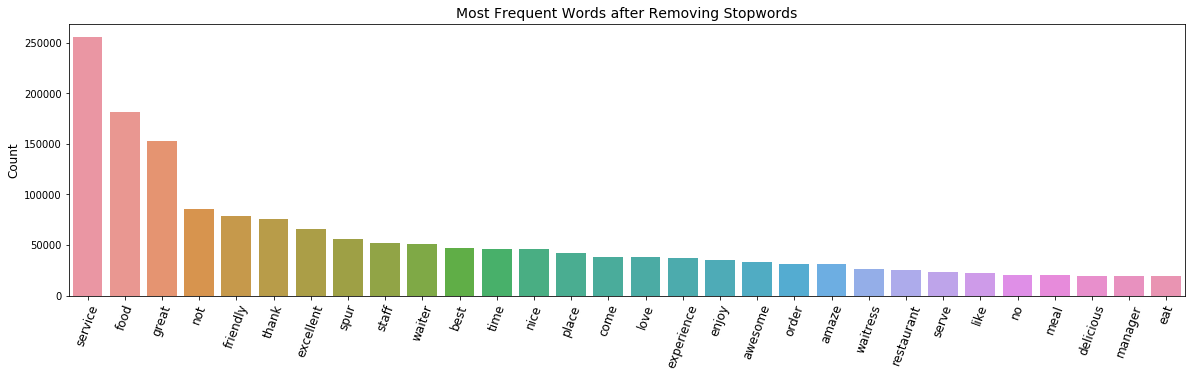

In [46]:
# plot word frequency after removing stopwords and lemmatizing 
def plot_word_freq(data, col, n_terms = 30, title=None):

    reviews = data[col].tolist().copy()
    review_tokens = list(itertools.chain.from_iterable(reviews))

    vocab = FreqDist(review_tokens)
    words_df = pd.DataFrame({'word':list(vocab.keys()), 'count':list(vocab.values())})

    d = words_df.nlargest(columns="count", n = n_terms) 
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=70, fontsize=12)
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=14)
    plt.show()
    
plot_word_freq(english, 'tokens_wesw', title='Most Frequent Words after Removing Stopwords')

In [47]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = BigramCollocationFinder.from_words(review_tokens_raw)

In [48]:
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:20] 

[(('the', 'food'), 46670),
 (('thank', 'you'), 41126),
 (('and', 'the'), 40597),
 (('food', 'was'), 38232),
 (('great', 'service'), 37526),
 (('service', 'was'), 36743),
 (('good', 'service'), 35412),
 (('the', 'service'), 34874),
 (('it', 'was'), 32085),
 (('the', 'best'), 26864),
 (('it', 'is'), 26160),
 (('food', 'and'), 25840),
 (('service', 'and'), 25042),
 (('excellent', 'service'), 24348),
 (('for', 'the'), 24094),
 (('was', 'very'), 23296),
 (('of', 'the'), 21630),
 (('friendly', 'and'), 21487),
 (('good', 'food'), 21174),
 (('had', 'a'), 20864)]

In [49]:
finder_tri = TrigramCollocationFinder.from_words(review_tokens_raw)
sorted(finder_tri.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:20] 

[(('the', 'food', 'was'), 19237),
 (('the', 'service', 'was'), 15522),
 (('the', 'food', 'is'), 8328),
 (('keep', 'it', 'up'), 7881),
 (('and', 'the', 'food'), 7859),
 (('food', 'and', 'service'), 7826),
 (('very', 'friendly', 'and'), 7150),
 (('thank', 'you', 'for'), 6886),
 (('service', 'was', 'excellent'), 6679),
 (('we', 'had', 'a'), 6044),
 (('keep', 'up', 'the'), 5951),
 (('and', 'the', 'service'), 5849),
 (('had', 'a', 'great'), 5831),
 (('the', 'service', 'is'), 5424),
 (('service', 'was', 'great'), 5084),
 (('service', 'was', 'good'), 5071),
 (('food', 'was', 'great'), 5023),
 (('one', 'of', 'the'), 5017),
 (('great', 'service', 'and'), 4952),
 (('good', 'food', 'and'), 4867)]

In [50]:
wesw_reviews = english['tokens_wesw'].tolist().copy()
review_tokens_wesw = list(itertools.chain.from_iterable(wesw_reviews))
finder = BigramCollocationFinder.from_words(review_tokens_wesw)
print('After lemming and removing stopwords, the bigrams look quite different.')
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:20] 

After lemming and removing stopwords, the bigrams look quite different.


[(('great', 'service'), 39958),
 (('excellent', 'service'), 25855),
 (('great', 'food'), 19189),
 (('service', 'great'), 18912),
 (('food', 'service'), 17775),
 (('service', 'food'), 17585),
 (('food', 'great'), 17398),
 (('friendly', 'staff'), 13923),
 (('service', 'excellent'), 13782),
 (('friendly', 'service'), 9692),
 (('service', 'thank'), 9093),
 (('staff', 'friendly'), 8154),
 (('play', 'area'), 7512),
 (('service', 'friendly'), 7477),
 (('best', 'service'), 6634),
 (('food', 'excellent'), 6223),
 (('awesome', 'service'), 6021),
 (('food', 'delicious'), 5834),
 (('customer', 'service'), 5824),
 (('great', 'experience'), 5593)]

In [51]:
finder_tri = TrigramCollocationFinder.from_words(review_tokens_wesw)
print('Likewise for the trigrams.')
sorted(finder_tri.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:20]

Likewise for the trigrams.


[(('food', 'great', 'service'), 5640),
 (('service', 'great', 'food'), 4496),
 (('great', 'food', 'great'), 3395),
 (('great', 'service', 'great'), 3169),
 (('great', 'service', 'food'), 2860),
 (('great', 'food', 'service'), 2722),
 (('service', 'friendly', 'staff'), 2593),
 (('food', 'excellent', 'service'), 2537),
 (('thank', 'great', 'service'), 2488),
 (('service', 'great', 'service'), 2171),
 (('great', 'service', 'thank'), 2041),
 (('service', 'excellent', 'food'), 2041),
 (('excellent', 'service', 'food'), 1872),
 (('service', 'excellent', 'service'), 1791),
 (('service', 'food', 'great'), 1750),
 (('food', 'service', 'great'), 1692),
 (('food', 'friendly', 'staff'), 1687),
 (('excellent', 'service', 'great'), 1576),
 (('great', 'service', 'friendly'), 1499),
 (('play', 'area', 'kid'), 1424)]

Further text exploration will be carried out in relation to analytics in other notebooks. For now, the preprocessed text was saved for the full English reviews and the labeled English reviews so that analysis could be carried out without having to rerun the preprocessing each time. 

[Return to Index](#index)